# IMPORTS

In [1]:
import cv2
import firebase_admin
import matplotlib.pyplot as plt
import tqdm
import json
import pandas as pd
import os, io
import yaml
import numpy as np

from selenium import webdriver

from arcgis.gis import GIS

from skimage.filters import gaussian
from cv2 import imread

from scipy import ndimage


from PIL import Image

from functools import reduce

from collections import namedtuple


from firebase_admin import credentials
from firebase_admin import firestore

In [2]:
import httplib2
import io
import argparse
import requests


from httplib2 import Http
from oauth2client import file,client, tools
from googleapiclient import discovery
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
from oauth2client.service_account import ServiceAccountCredentials

SCOPES = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive',
         'https://www.googleapis.com/auth/drive.file',
         'https://www.googleapis.com/auth/spreadsheets.currentonly',
         'https://www.googleapis.com/auth/spreadsheets',
         'https://www.googleapis.com/auth/presentations',
         'https://www.googleapis.com/auth/drive.scripts',
         'https://www.googleapis.com/auth/drive.appdata',
         'https://www.googleapis.com/auth/drive.metadata'
        ]
store = file.Storage('/Users/daniel/OAN/credentials/storage.json')
creds = store.get()
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('/Users/daniel/OAN/credentials/storage.json', SCOPES)
    creds = tools.run_flow(flow, store)
drive_service = discovery.build('drive', 'v3', http=creds.authorize(Http()))
sheet_service = discovery.build('sheets', 'v4', http=creds.authorize(Http()))

In [ ]:
#TO UPLOAD SHEETS OR FILTES TO DRIVE
def uploadFile(filename,filepath,folder_id,filetype,fileapp):    
    file_metadata = { 'name': filename,
                      'parents': [folder_id],
                      'mimeType': fileapp,
                    }  
                                                  
                             

    media = MediaFileUpload(filepath,
                            mimetype=filetype)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()
    
    #permission = drive_service.permissions().get(
        #fileId=file.get('id'), permissionId="-").execute()
    
    #permission['role'] = "owner"
    
    #return drive_service.permissions().update(
        #fileId=file.get('id'), permissionId="-", body=permission, transferOwnership=True).execute()

In [3]:
ID='1sieUlrazfvmVT7OKk5ll8SQ-dtOsglkSEHnNhnVbsog'

In [786]:
RANGE_NAME = 'ARCGIS'
    
gsheet = sheet_service.spreadsheets().values().get(spreadsheetId=ID, range=RANGE_NAME).execute()

df_villages=pd.DataFrame(gsheet.get('values', [])[1:],columns= gsheet.get('values', [])[0:1][0])

## ESRI AUTH

In [223]:
cred_map='/Users/daniel/OAN/credentials/maps.yaml'

In [224]:
cred_map_yaml=yaml.load( open(cred_map, "r" ),Loader=yaml.FullLoader)

In [225]:
os.environ["ESRI_PASS"]=cred_map_yaml["ESRI_PASS"]

In [226]:
gis = GIS(profile='dani_oan', password=os.environ["ESRI_PASS"])

## FUNCTIONS

In [119]:

Point = namedtuple('Point', 'x y')

def points_adjoin(p1, p2):
    # to accept diagonal adjacency, use this form
    #return -1 <= p1.x-p2.x <= 1 and -1 <= p1.y-p2.y <= 1
    return (-1 <= p1.x-p2.x <= 1 and p1.y == p2.y or
             p1.x == p2.x and -1 <= p1.y-p2.y <= 1)

def adjoins(pts, pt):
    return any(points_adjoin(p,pt) for p in pts)

def locate_regions(datastring):
    data = datastring
    regions = []
    datapts = [Point(x,y) 
                for y in range(len(data[0]))
                    for x in range(len(data)) if data[x][y]==1]
    for dp in datapts:
        # find all adjoining regions
        adjregs = [r for r in regions if adjoins(r,dp)]
        if adjregs:
            adjregs[0].add(dp)
            if len(adjregs) > 1:
                # joining more than one reg, merge
                regions[:] = [r for r in regions if r not in adjregs]
                regions.append(reduce(set.union, adjregs))
        else:
            # not adjoining any, start a new region
            regions.append(set([dp]))
    return regions

def region_index(regs, p):
    return next((i for i,reg in enumerate(regs) if p in reg), -1)

def print_regions(regs):
    maxx = max(p.x for r in regs for p in r)
    maxy = max(p.y for r in regs for p in r)
    allregionpts = reduce(set.union, regs)
    line = np.ones((maxx+4,maxy+3)) #  empty regular list
    
    for y in range(-1,maxy+2):
        
        for x in range(-1,maxx+2):
            p = Point(x, y)
            if p in allregionpts:
                line[x][y]=1
            else:
                line[x][y]=0


    return line
# test against data set

def get_coord(m_x,m_y,center,im):
     #Lat = Y Long = X
    
    #got manually GMAPS
    #range_x_long=abs(9.96243-9.95707)
    #range_y_lat=abs(2.94223 - 2.95123)
    
    #got manually ESRI
    range_x_long=abs(9.906701-9.900391)
    range_y_lat=abs(3.406537 - 3.398512)
    
    
    y_size=len(im[0])
    x_size=len(im)
    
    
    lat_y=center[0] + range_x_long/2 - m_y*range_x_long/x_size
    long_x=center[1] - range_y_lat/2 + m_x*range_y_lat/y_size
    
    return (lat_y,long_x)

In [7]:
def read_image(image):
    kk = imread(image,-1)
    #plt.figure()
    #plt.imshow(kk)
    return kk
def read_image_gray(image):
    bgr_img = imread(image,0) #cv2.IMREAD_GRAYSCALE
    #plt.figure()
    #plt.imshow(bgr_img)
    return bgr_img
def segmentation_by_color(image,th):
    ret,im_thresh= cv2.threshold(image,th,255,cv2.THRESH_BINARY_INV)
    #print (init)
    '''
    alpha Higher values make snake contract faster
    beta Highervalue make snake smoother
    Gamma Timestepping parameter
    '''
    #plt.figure()
    #plt.imshow(im_thresh)
    return im_thresh
#smooth and threshold as image has compression artifacts (jpg)
def gaus_filter(image,sigma):
    im = ndimage.gaussian_filter(image/2, sigma)
    im[im<10]=0
    im[im>=10]=255
    blobs, number_of_blobs = ndimage.label(im)

    #plt.figure()
    #plt.imshow(blobs)
    
    return blobs
def polarisation(blobs):
    a=blobs/255

    a=np.where(a==0, 2, a)
    a=np.where(a!=2, 0, a)
    a=np.where(a==2, 1, a)
    
        
    #plt.figure()
    #plt.imshow(a)
    
    return a
def region_detection(a):
    regs = locate_regions(a)

    #line = print_regions(regs)

    #plt.figure(figsize = (20,10))
    #plt.imshow(line)

    print("Number of HOUSES FOUND : % 3d"%(len(regs)))
    return regs

def count_regions_and_plot_and_getcoord(regs,size,begin,im,center):  
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    ax.imshow(im)
    size_thr=size
    j=0
    coord=[]
    for reg,x_beg in zip(regs,begin):
        if len(reg)>0:
            for i,r in enumerate(reg):
                size_reg = len(r)
                if size_reg > size_thr:
            
                    pixels_x = [p.y for p in r]
                    pixels_y = [p.x+x_beg  for p in r]
            
                    m_x = np.mean(pixels_x)
                    m_y = np.mean(pixels_y)
                    
                    
                    coord.append(get_coord(m_x,m_y,center,im))
                    #print(i,m_x,m_y)
            
                    r = max([(max(pixels_x)-min(pixels_x)),(max(pixels_y)-min(pixels_y)),10])
            
                    s = np.linspace(0, 2*np.pi, int(r/2))
            
                    c = m_x + 3*np.cos(s)
                    d = m_y + 3*np.sin(s)
                    init = np.array([c, d]).T
            
                    ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
                    #ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
            
                    # ax.set_xticks([]), ax.set_yticks([])
                    #ax.axis([0, bgr_img.shape[1], bgr_img.shape[0], 0])
            
                    j += 1
            
    d = len(im)/2 + 1*np.cos(s)
    c = len(im[0])/2 + 1*np.sin(s)
    init = np.array([c, d]).T   
    #ax.plot(init[:, 0], init[:, 1], '--b', lw=3)
    print("Number of HOUSES FOUND WITH SIZE FILTER %1d pixels: % 3d"%(size_thr,j))
    print("Population Estimate: % 3d"%(j*5.8))
    plt.show() 
    return coord

In [38]:
def crop(image_path, coords, saved_location):
    """
    @param image_path: The path to the image to edit
    @param coords: A tuple of x/y coordinates (x1, y1, x2, y2)
    @param saved_location: Path to save the cropped image
    """
    image_obj = Image.open(image_path)
    cropped_image = image_obj.crop(coords)
    cropped_image.save(saved_location)

## OPEN FIRST VILLAGE

In [787]:
n_vil=9

In [788]:
village=df_villages.loc[n_vil,'Translate']
village

'GORI'

In [789]:
overpass_url = "http://overpass-api.de/api/interpreter"

#When the village is well defined
overpass_query = ("""
[out:json];
area['name'='"""+village+
"""']->.a;
way[building](area.a);
(._;>;);
out body;
""")

#When the village is a dot or something
overpass_query_2 = ("""
[out:json];
way['name'='"""+village+
"""'];
way(around:1000)[building];
(._;>;);
out body;
""")

#get Data
response = requests.get(overpass_url, 
                        params={'data': overpass_query_2})
#response_2 = requests.get(overpass_url, 
#                        params={'data': overpass_query_2})
data = response.json()
#data = response_2.json()

In [790]:
houses = []
ways=[elem for elem in data['elements']  if elem['type']=='way']
nodes=[elem for elem in data['elements']  if elem['type']=='node']
for way in ways:
    houses_info={}
    houses_info['id']=way['id']
    nodes_lats=[]
    nodes_longs=[]
    houses_info['nodes']=way['nodes']
    for node in nodes:
        if node['id'] in houses_info['nodes']:
            nodes_lats.append(node['lat'])
            nodes_longs.append(node['lon'])
    houses_info['lat']=np.mean(np.array(nodes_lats))
    houses_info['lon']=np.mean(np.array(nodes_longs))
    houses.append(houses_info)

In [791]:
df_houses=pd.DataFrame(houses)

In [792]:
len(df_houses)

236

In [793]:
df_houses.head(4)

,id,nodes,lat,lon
0,514973934,"[5030191718, 5030191717, 5030191716, 503019171...",9.938268,3.182851
1,514973936,"[5030193122, 5030193121, 5030191720, 503019171...",9.938681,3.182245
2,514973938,"[5030193126, 5030193125, 5030193124, 503019312...",9.938412,3.181935
3,514973939,"[5030193130, 5030193129, 5030193128, 503019312...",9.938348,3.181782


In [794]:
#Mapbox
#center=(df_houses.lon.mean(),df_houses.lat.mean())
#googleMaps
center=(df_houses.lat.mean(),df_houses.lon.mean())
size=800
lat=center[0]
long=center[1]
lat_long=center

#TO CONVERT TO COORDS
lat_screen=float(lat_long[1])
long_screen=float(lat_long[0])

center

(9.936155557309322, 3.182051171822034)

# OPEN MAP

In [795]:
ex_map = gis.map(zoomlevel=17)

In [796]:
ex_map.layout={'height':'600px','width':'800px'}

In [797]:
ex_map.center =center
ex_map.basemap = 'satellite'

In [798]:
ex_map

MapView(layout=Layout(height='600px', width='800px'), zoom=17.0)

# EXPORT MAP

# HTML

In [799]:
ex_map.export_to_html('pic_maps/'+village+'_gmap.html')

True

## ADD HOUSES

In [800]:
gis_houses=gis.content.import_data(df_houses)

In [801]:
ex_map.add_layer(gis_houses)

In [802]:
ex_map

MapView(jupyter_target='notebook', layout=Layout(height='600px', width='800px'), ready=True, zoom=17.0)

In [803]:
ex_map.export_to_html('pic_maps/'+village+'_gmap_with_dots.html')

True

In [660]:
#OTHER
#gis_houses_dict = dict(gis_houses.properties)
#houses_json = json.dumps({"featureCollection": {"layers": [gis_houses_dict]}})

In [661]:
#houses_item_properties = {'title': 'Ports to the south of SFO along west coast of USA',
#                        'description':'Example demonstrating conversion of pandas ' + \
#                         'dataframe object to a GIS item',
#                        'tags': 'arcgis python api, pandas, csv',
#                        'text':houses_json,
#                        'type':'Feature Collection'}
#
#houses_items = gis.content.add(houses_item_properties)

In [662]:
#ex_map

# Telecharget l'image

In [30]:
driver = webdriver.Chrome(executable_path=
                          r'/Users/daniel/OAN/nikki_map_house_count/maps_scrapping/chromedriver')

In [804]:
file = "file:/Users/daniel/OAN/nikki_map_house_count/all_tog/pic_maps/"+village+'_gmap.html'

In [805]:
driver.get(file)

In [806]:
screen=driver.save_screenshot('pic_maps/'+village+'.png')

## CUT IMAGE

In [807]:
crop('pic_maps/'+village+'.png',(100, 100, 1600, 1300),'pic_maps/'+village+'2.png')

# CONNECT TO FIREBASE

In [599]:
filename='/Users/daniel/OAN/credentials/firebase_parameters.json'

In [38]:
# Use a service account
cred = credentials.Certificate(filename)
firebase_admin.initialize_app(cred)

db = firestore.client()

# COUNT HOUSES

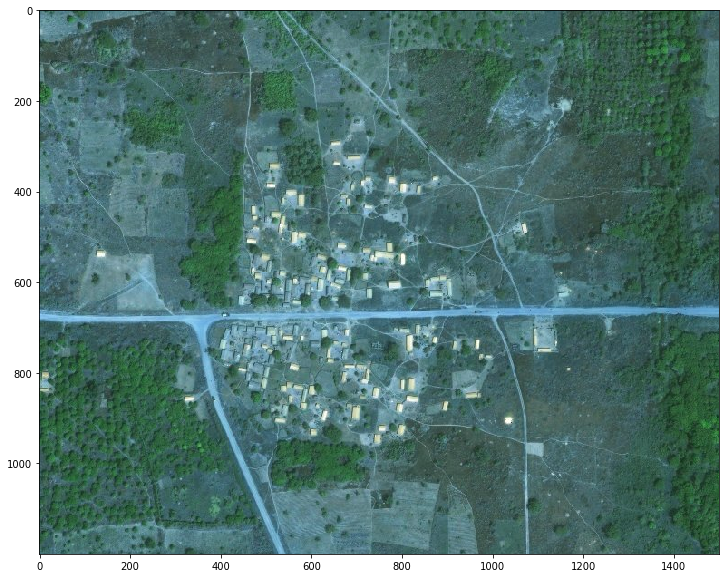

In [808]:
image ='pic_maps/'+village+'2.png'

im=read_image(image)

plt.figure(figsize=(20,10))
plt.imshow(im)

In [809]:
village

'GORI'

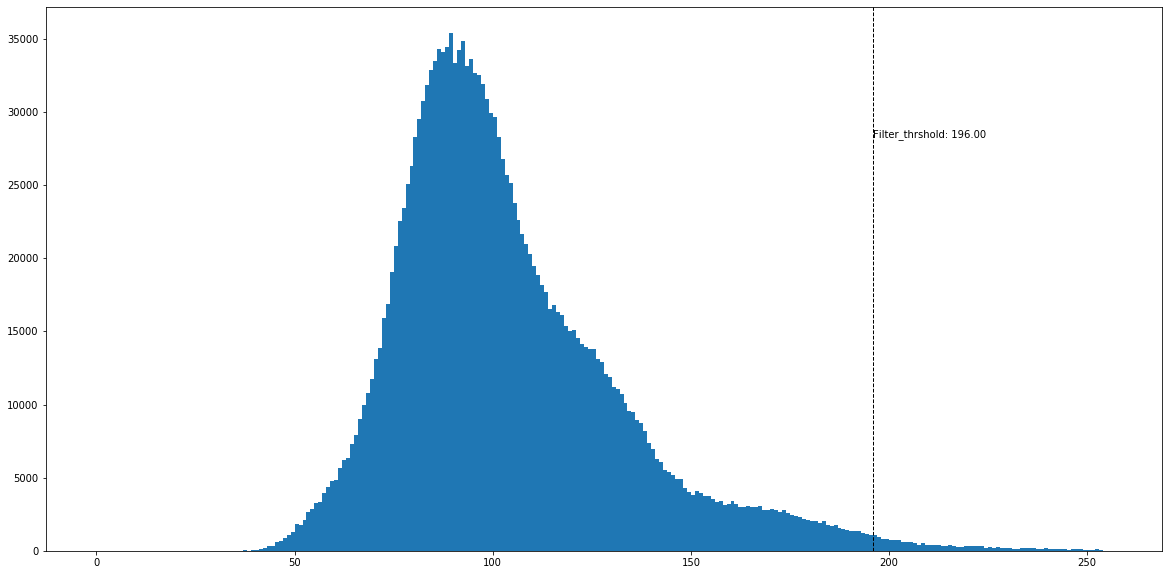

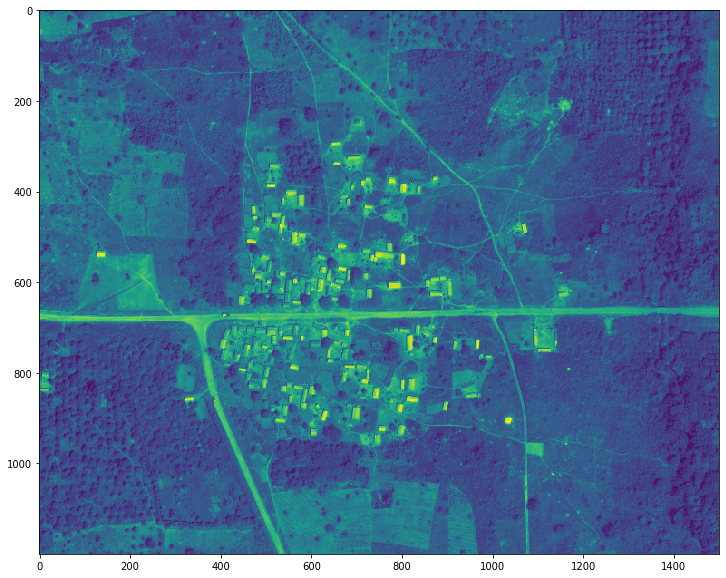

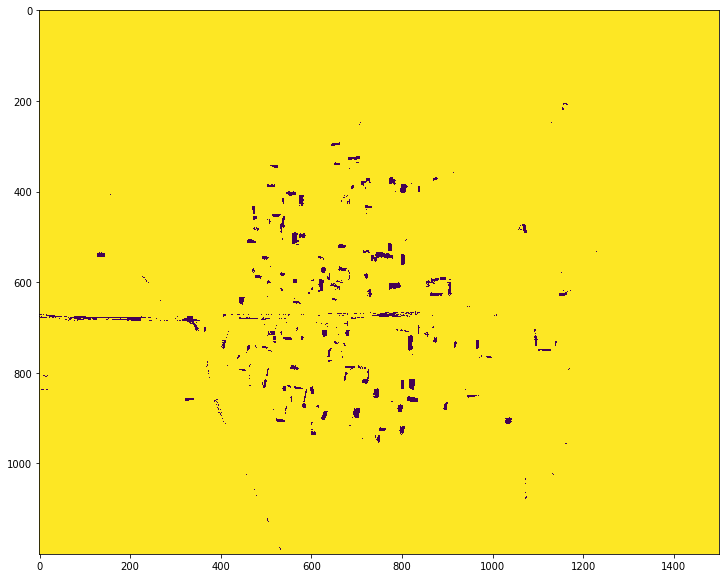

In [810]:
gr_image = read_image_gray(image)

pixels=gr_image.ravel()

f,ax = plt.subplots(figsize=(20,10))

n, b, patches =ax.hist(pixels,256,[0,256])

quantile=0.99

filter_thrs = np.quantile(pixels,quantile)

ax.axvline(filter_thrs, color='k', linestyle='dashed', linewidth=1)


bin_max = n.max()



ax.text(filter_thrs, bin_max*0.8, 'Filter_thrshold: {:.2f}'.format(filter_thrs))

plt.figure(figsize=(20,10))
plt.imshow(gr_image)

s_image = segmentation_by_color(gr_image,filter_thrs)

plt.figure(figsize=(20,10))
plt.imshow(s_image)

In [811]:
np.quantile(gr_image.ravel(),quantile)

196.0

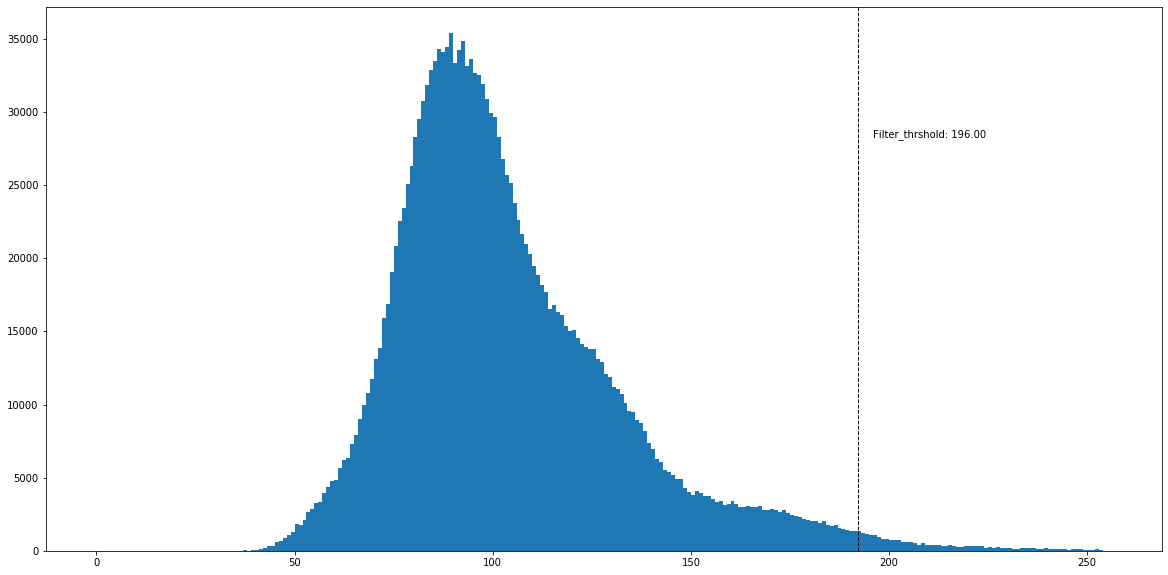

<Figure size 1440x720 with 0 Axes>

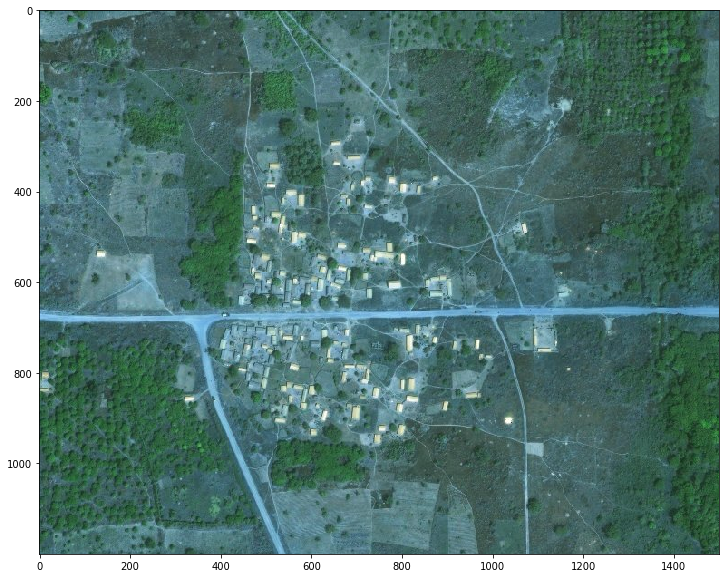

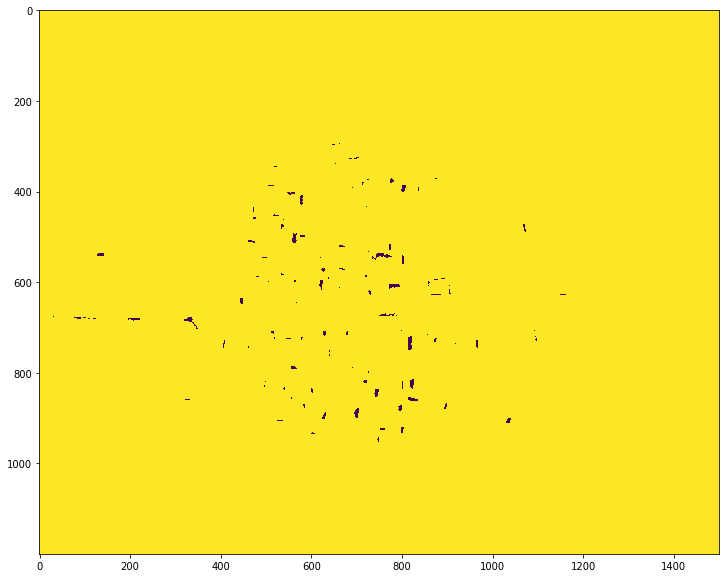

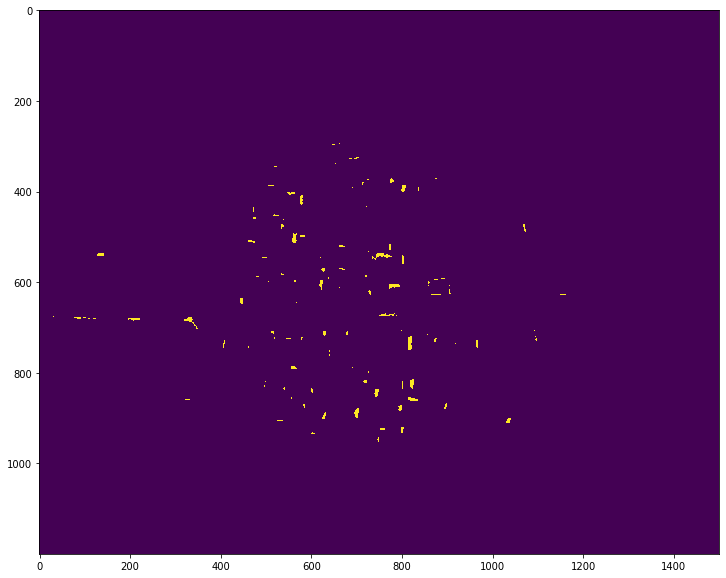

In [812]:
size_pixel_region=4

gr_image = read_image_gray(image)

pixels=gr_image.ravel()

f,ax = plt.subplots(figsize=(20,10))

n, b, patches =ax.hist(pixels,256,[0,256])


filter_thrs = np.quantile(pixels,quantile)

ax.axvline(filter_thrs*0.98, color='k', linestyle='dashed', linewidth=1)

bin_max = n.max()

ax.text(filter_thrs, bin_max*0.8, 'Filter_thrshold: {:.2f}'.format(filter_thrs))

plt.show()


s_image = segmentation_by_color(gr_image,filter_thrs)

plt.figure(figsize=(20,10))


sigma=1.2
blobs = gaus_filter(s_image,sigma)
a = polarisation(blobs)


plt.figure(figsize=(20,10))
plt.imshow(im)


plt.figure(figsize=(20,10))
plt.imshow(blobs)

plt.figure(figsize=(20,10))
plt.imshow(a)

Computing image nº 0: 100%|██████████| 1/1 [00:06<00:00,  6.14s/it]

Number of HOUSES FOUND:  113


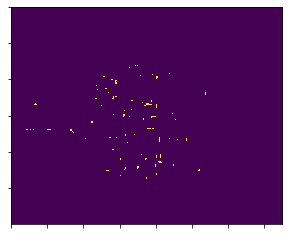

In [813]:
regs = []
begin = []
size_pixel_region=4
p_1=np.count_nonzero(a == 1)/(np.count_nonzero(a == 0)+np.count_nonzero(a == 1))
n=max(int(p_1*160),1)
z=0
for chop in tqdm.tqdm([a[int(i*len(a)/n):int((i+1)*len(a)/n)] for i in range(n)],
                          desc = 'Computing image nº %1d'% ( z )):
    
    reg = locate_regions(chop) 

    regs.append(reg)
    begin.append(z*len(a)/n)
    z+=1

    f, ax = plt.subplots()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(chop)

    print("Number of HOUSES FOUND: % 3d"%(len(reg)))


Number of HOUSES FOUND WITH SIZE FILTER 4 pixels:  97
Population Estimate:  562


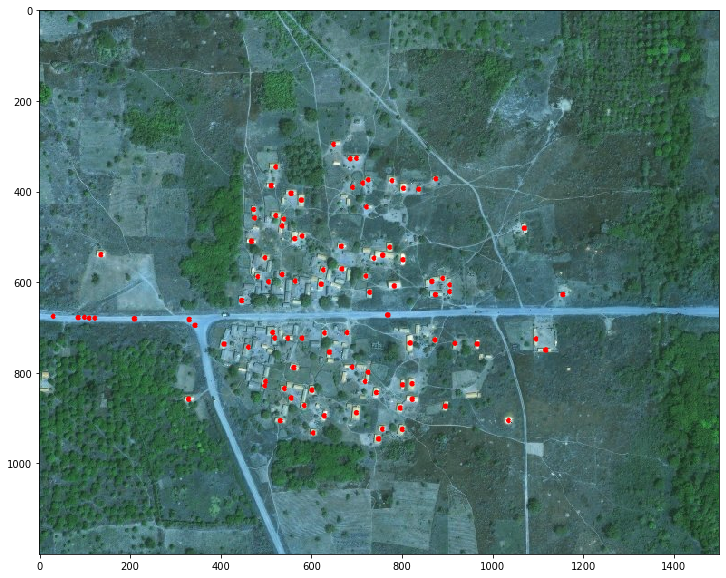

In [962]:
if len(regs)>0:
    long_crop_center = long_screen+abs(9.9598-9.9597)
    lat_crop_center= lat_screen + abs(2.947-2.94672)
    ct=(long_crop_center, lat_crop_center)
    
    coords=count_regions_and_plot_and_getcoord(regs,size_pixel_region,begin,im,ct)


In [963]:
#SAVE COORDS IN DATAFRAME
df_houses_alg=pd.DataFrame(coords,columns=['latitude','longitude'])

In [816]:
village

'GORI'

In [817]:
len(df_houses)

236

In [818]:
len(df_houses_alg)

97

# CHECK COORDS

In [964]:
gis_houses_alg=gis.content.import_data(df_houses_alg)

In [965]:
ex_map_2 = gis.map(zoomlevel=17)

In [966]:
ex_map_2.layout={'height':'600px','width':'800px'}

In [967]:
ex_map_2.center = center
ex_map_2.basemap = 'satellite'

In [968]:
ex_map_2.add_layer(gis_houses_alg)

In [969]:
ex_map_2

MapView(layout=Layout(height='600px', width='800px'), zoom=17.0)

In [970]:
ex_map.export_to_html('pic_maps/'+village+'_gmap_with_alg.html')

True

# SAVE IN GSHEETs

In [971]:
nom='df_houses_alg_'+str(n_vil)+'_'+village
df_houses_alg.to_csv(nom+'.csv')

In [972]:
drive_id_folder='1260i6QGMSd9aUdGHz9uez0ru523vCfq7'
uploadFile(nom + ".csv",
           nom + ".csv",
           drive_id_folder,"text/csv",'application/vnd.google-apps.spreadsheet')
os.remove(nom+'.csv')

In [973]:
nom='df_houses_'+str(n_vil)+'_'+village
df_houses.to_csv(nom+'.csv')

In [974]:
drive_id_folder='1260i6QGMSd9aUdGHz9uez0ru523vCfq7'
uploadFile(nom + ".csv",
           nom + ".csv",
           drive_id_folder,"text/csv",'application/vnd.google-apps.spreadsheet')
os.remove(nom+'.csv')

# UPLOAD TO MYMAPS

click to see results

<a href="https://www.google.com/maps/d/edit?mid=1MtbdRCmYDSSSWThGlJ_ZYkJhvRczLeBl&ll=9.936057100985765%2C3.2051019633502165&z=17" target="_parent"><img src="https://lh4.googleusercontent.com/wFWTbQtnm83_tZYhu2w18mjQ8JGJ2OD_fE_dwFUHAQVm_O3tpQVnzB3vD_kwo0MXiapCG2SNQqRtx_uU4ydC-mBgRkiMfCPa_TZh79BOZMeY8Kh2zi4gYDRixc1SPmnNmQWuZDBN" alt="Open Maps"/></a>


## upload to firebase

In [354]:
#Convert info to dict and upload to firebase
houses = df_houses.to_dict('index')
houses_dict = [{k: v} for k, v in houses.items()] 
houses_l_dict = []
for i,house in enumerate(houses_dict):
    id_house=list(house.keys())[0]
    new_data={'coordinates':{
                    'longitude':house[id_house]['longitude'],
                    'latitude':house[id_house]['latitude']}
             }
    houses_l_dict.append(new_data)

    db.collection(u'houses').add(new_data)

# Distance to pompe

In [512]:
def distace_topump(x,coord_pump):
    x_dist = abs(coord_pump[0]-x['latitude'])*111111 
    y_dist = abs(coord_pump[1]-x['longitude'])*111111 
    distance = math.sqrt(x_dist**2+y_dist**2)
    
    return distance
    

In [542]:
coord_pump=(long,lat)
df_houses['distance']=df_houses.apply(lambda x: distace_topump(x,coord_pump),axis=1)

In [543]:
#4km/h speed walk, how many minutes in average people do to the source
dist_in_min=df_houses['distance'].mean()*60/4000
print('Mean average time to pump %3.2f min'%(dist_in_min))

Mean average time to pump 7.29 min
